Agent is on a gridlike frozen lake structure. certain grid points have unfrozen water. the grid also has a point with the objective destination. the goal is to get the agent to reach the objective without leaving the bounds of the grid, and without falling into the water grid points.

The grid is 4 x 4 units, therfore there are 16 total positions, and 15 total states, including the 0 index starting state (agent starts in the top left grid unit). episode ends when the agent reaches the goal, or when the agent falls into the holes. the reward of reaching the goal is +1.

Why not use DFS or BFS to find the path? there is an additional is_slippery condition of this environment. if the agent decides to move in any direction, there is a chance that the agent will 'slip' and instead move into any one of the adjacent directions.

Epsilon Greedy Algorithm:
start epsilon value is 1. with a probability of (1 - epsilon) a random action is taken, which is the exploration of new strategies that the agent may take. with a probability of (epsilon) the most optimal action of the existing strategy is taken. At the end of each episode, the epsilon value is subtracted by epsilon decay rate.

Q-Table / Tabular Q-Learning:
if we were to use this method of training our agent, the strategy/policy of the agent would be a table of 2-dimensions. there would be 4 columns representing each possible action, and 16 rows representing each possible state (0 to 15). each of the entries of the table represents the expected future reward of taking that action in that position.

DQN:
functions like a regular feedforward network. input layer has 16 nodes (one for each state). output layer has 4 nodes (one for each action). If the agent is at any particular state, that state layer node value is 1, and the rest are 0. the output layer values are Q-values, each representing the expected future reward of that action at that state. between each input and output layer exists one hidden layer. this layer consists of nodes that each apply a weighted sum of the inputs, followed by a non-linear activation function like ReLU. Hidden layers allow the network to learn complex and non-linear patterns between different states and actions. for example, the hidden layer may learn to identify states that are associated with falling into a hole at some nearby future state. In this environment, only one hidden layer is necessary, but more hidden layers can result in more nuanced relationships between states and optimal actions.

Q-Learning objective function:
q[state, action] = q[state, action] + learning_rate * (reward + discount_factor * max(q[new_state,:]) - q[state, action])

DQN objective function:
q[state, action] = reward if new_state is terminal else
                   reward + discount_factor * max(q[new_state,:])

We will have 2 FFN's for our agent: one for training its policy, and one for the target. initially, these will be copies of one another. for each state, the expected future reward of the possible actions is calculated in the policy FFN, and this is copied over to the target FFN. after the agent makes the move that is associated with a particular action, that action's actual expected future reward is the one we set for the target FFN action node q-values. then we transfer these q-values back into the q-values of our policy FFN. in simpler terms, the agent acts in the behavior of the policy FFN, and then its policy q-values are updated to reflect the actual reward of the actions taken.

Experience Replay:
we need a way for the agent to memorize the actions, steps and rewards after each action. after the action is taken, we save the state, action, new_state, reward, and terminated (boolean value), into its memory. Then we randomly select batches from this memory and optimize using torch.optim functions.


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

In [3]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)    
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)

    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else. 
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
            
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions    

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('frozen_lake_dql.png')

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%4==0:
                print() # Print a newline every 4 states

Policy (random, before training):
00,U,[+0.28 +0.01 +0.28 +0.38] 01,U,[+0.16 +0.08 +0.22 +0.36] 02,U,[+0.21 +0.01 +0.24 +0.29] 03,U,[+0.33 +0.10 +0.23 +0.35] 
04,U,[+0.16 -0.03 +0.19 +0.34] 05,U,[+0.23 +0.06 +0.23 +0.26] 06,U,[+0.11 -0.03 +0.22 +0.35] 07,U,[+0.14 +0.08 +0.18 +0.27] 
08,R,[+0.24 +0.03 +0.37 +0.32] 09,L,[+0.33 -0.03 +0.20 +0.31] 10,U,[+0.25 +0.03 +0.21 +0.26] 11,U,[+0.22 +0.10 +0.24 +0.25] 
12,U,[+0.25 +0.07 +0.23 +0.27] 13,R,[+0.23 +0.07 +0.25 +0.25] 14,L,[+0.29 +0.07 +0.22 +0.10] 15,U,[+0.27 +0.06 +0.25 +0.38] 
Policy (trained):
00,D,[+0.52 +0.59 +0.47 +0.54] 01,L,[+0.53 +0.14 +0.48 +0.49] 02,D,[+0.44 +0.66 +0.38 +0.49] 03,L,[+0.43 +0.17 +0.40 +0.40] 
04,D,[+0.58 +0.66 -0.00 +0.57] 05,D,[+0.41 +0.64 +0.53 +0.54] 06,D,[+0.17 +0.80 +0.04 +0.47] 07,D,[+0.35 +0.55 +0.38 +0.45] 
08,R,[+0.66 +0.00 +0.73 +0.59] 09,R,[+0.65 +0.81 +0.81 -0.00] 10,D,[+0.72 +0.90 +0.00 +0.71] 11,D,[+0.46 +0.72 +0.48 +0.63] 
12,D,[+0.50 +0.65 +0.51 +0.48] 13,R,[-0.01 +0.81 +0.90 +0.74] 14,R,[+0.81

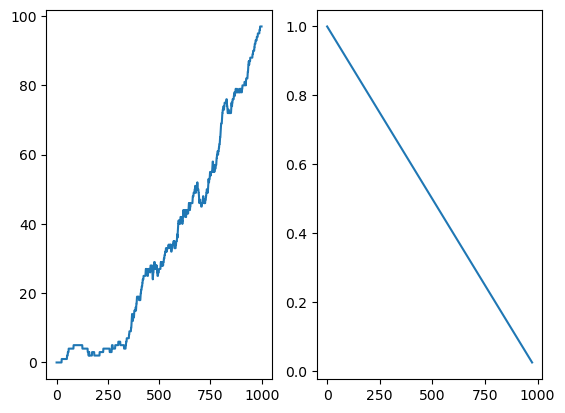

: 

In [7]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = False
    frozen_lake.train(1000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)